# Proyecto Integrador - Comunicaciones Digitales

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

## I. INTRODUCCIÓN Y PARÁMETROS 

En esta Jupyter Notebook se realizaran distintas simulaciones con el fin de comprender en profundidad la modulación LoRa. Para abordar los aspectos teóricos de este tipo de modulación, se utilizaran los siguientes documentos:

- Paper: _Frequency Shift Chirp Modulation: The LoRa Modulation_ – Lorenzo Vangelista.
    
- Paper: _From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation_.
    
- Libro: _Principles of Digital Communication: A Top-Down Approach_ – Bixio Rimoldi.
    

La modulación LoRa (FSCM – _Frequency Shift Chirp Modulation_) es ideal para el Internet de las Cosas (IoT), especialmente en entornos de largo alcance y bajo consumo de energía, debido a su alta inmunidad al ruido y su capacidad para atravesar canales selectivos. Esta técnica consiste en modular el mensaje a transmitir mediante una señal senoidal cuya frecuencia varia de forma continua y lineal. A dicha señal se la denomina _chirp_, y se estudiara en detalle más adelante.  

Para las simulaciones se tendrán en cuenta las siguientes definiciones de los parámetros que caracterizan a esta modulación:

**SF – Spreading Factor:**

- Definió el número de bits codificados en cada símbolo. Su valor fue SFSFSF.
- Fue un número entero que usualmente tomó valores en {7,8,9,10,11,12}\{7,8,9,10,11,12\}{7,8,9,10,11,12}.
    

**Ts – Tiempo de símbolo:**

- Representó el tiempo necesario para transmitir un símbolo. Se calculó como:  
    Ts=2SFBWTs = \frac{2^{SF}}{BW}Ts=BW2SF​
    

**BW – Ancho de banda:**

- Corresponde al ancho de banda utilizado en la transmisión. Su valor fue BWBWBW.
    

**T – Tiempo de muestra:**

- Intervalo entre muestras consecutivas. Se calculó como:  
    T=1BWT = \frac{1}{BW}T=BW1​
    

**s – Símbolo enviado:**

- Símbolo transmitido, el cual tomó valores en el conjunto:  
    s∈{0,…,2SF−1}s \in \{0, \dots, 2^{SF} - 1\}s∈{0,…,2SF−1}
    

**Relación señal-ruido (SNR):**

- Relación entre la potencia de la señal y la del ruido, expresada en decibelios (dB).
- Indicó cuán ruidoso fue el canal de comunicación.


Tal como se plantea en el libro Bixio, podemos dividir el proceso de la comunicación en los siguientes bloques:  

1. Encoder  
2. Waveform Former  
3. N-Tuple Former  
4. Decoder

A continuación, se describirán en detalle cada uno de estos bloques, aplicando los conceptos presentados en el paper de Vangelista. 

## II. ENCODER

El primer bloque que implementaremos es el **Encoder**, este es el encargado de generar el símbolo correspondiente a la cadena de bits de dimensión SF que buscamos transmitir. El símbolo generado sera un numero entero positivo.

Podemos notar que en el fondo estamos realizando una conversión de binario a decimal.

Para realizar el encoder se tuvo en cuenta la siguiente formula del paper de Lorenzo Vangelista: <br>


$$s(nTs) = \sum_{h=o}^{SF - 1} w(nTs)_h * 2^h $$

  

Donde:

- s(nTs) Es el símbolo generado

- w(nTs) Es un vector de bits de tamaño SF


De acuerdo con la convención establecida en el libro Bixio, podemos denominar a la cadena de bits como las hipótesis y al símbolo como la palabra código.

In [1]:
def encoder(bits, SF):
    simbolo = 0
    
    for j in range(SF):   
        ponderacion = 2 ** (SF - 1 - j)
        simbolo = bits[j] * ponderacion + simbolo

    return simbolo

## III. WAVEFORM FORMER

En esta etapa del proceso, nos encargaremos de generar una forma de onda que contenga en ella el símbolo codificado. Para ello, haremos uso de la formula desarrollada por Lorenzo Vangelista:

$$ c(nTs + kT) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi[(s(nTs)+k)_{mod}2^{SF}]kT \frac{B}{2^{SF}}} $$

para $ k = 0,1,...,2^{SF}-1$

  

Donde:

- $ c(nTs + kT) $ Son las waveform's de los s(nTs) desplazadas en k múltiplos de T.
- $ e^{j2\pi[(s(nTs)+k)_{mod}2^{SF}]kT \frac{B}{2^{SF}}} $ Es una exponencial compleja con frecuencia variable linealmente en el tiempo.

Usamos una base ortogonal que es la exponencial
Porq usamos una base ortogonal
Como lo llama en el libro de bixio


In [17]:
def print_waveform_former(señal, señalF):
  print("----------------------------------------------------------------- WAVEFORM FORMER -----------------------------------------------------------------------------")

  t = np.arange(0, len(señal), 1)

  plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
  plt.subplot(3,1,1)
  plt.plot(t, np.real(señal))
  plt.title('Símbolo s modulado en el tiempo, parte real')
  plt.xlabel('tiempo')
  plt.ylabel('amplitud')   
  plt.grid()

  plt.subplot(3,1,2)   
  plt.plot(t, np.imag(señal))
  plt.title('Símbolo s modulado en el tiempo, parte imaginaria')
  plt.xlabel('tiempo')
  plt.ylabel('amplitud')
  plt.grid()
    
  plt.subplot(3,1,3)
  plt.plot(t, señalF)
  plt.title('Variación lineal de la frecuencia')
  plt.xlabel('tiempo')
  plt.ylabel('Frecuencia')
  plt.grid()

  plt.subplots_adjust(left=0.125,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.2,
                  hspace=0.35)

  plt.show()

  print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

def waveform_former(simbolo, SF, BW):
  T = 1 / BW
  numMuestras = 2 ** SF
    
  señal = np.zeros(numMuestras, dtype=complex)
  señalF = np.zeros(numMuestras, dtype=int)
    
  for k in range(numMuestras):
    f = (simbolo + k) % numMuestras 
    t = k * T
        
    muestra = (1 / (np.sqrt(numMuestras))) * np.exp(1j * 2 * np.pi * f * t)
    
    señal[k] = muestra
    señalF[k] = f
  
  return señal, señalF

## N-TUPLE FORMER
Una vez que se recibe la señal enviada es necesario desmodularla para decodificar el símbolo transmitido. El paper de Lorenzo Vangelista habla sobre un "truco" matemático que nos permite realizar la desmodulación de una forma mucho más eficiente y fácil. La formula que se plantea es la siguiente

$$ \sum_{k=o}^{2^{SF} - 1} r(nTs + kT) * e ^ {-j2\pi\frac{k^2}{2^{SF}}} * \frac{1}{\sqrt{2^{SF}}} e ^ {-j2\pi pk \frac{1}{2^{SF}}}$$

Podemos descomponer la formula en dos etapas:<br>
- En la primer etapa se multiplica la señal recibida muestra a muestra por la exponencial compleja que llamaremos down chirp. El resultado de esta etapa lo denotaremos $ d(nTs + kTs) $
- En la segunda etapa tomamos la transformada discreta de fourier al vector $ d(nTs) $. El simbolo estimado sera el indice del valor maximo de la transformada.

Remarcar que estamos proyectanmdo sobre la base del transmisor
POrq podemos hacer esto
Explicar cual es el desarrollo matematico correcto y como lo terminamos resolviendo y de donde sale eso


In [18]:
def generate_downChirp(SF, BW, numMuestras):
    T = 1 /  BW

    downChirp = np.zeros(numMuestras, dtype=complex)
    downChirpF = np.zeros(numMuestras, dtype=int)

    for k in range (numMuestras):
        f = k % numMuestras
        t = k * T
        
        muestra = (1 / (np.sqrt(BW))) * np.exp(-1j * 2 * np.pi * f * t)

        downChirp[k] = muestra
        downChirpF[k] = f
    
    return downChirp, downChirpF

def print_downChirp(downChirp, downChirpF, numMuestras):
    print("----------------------------------------------------------------- NTUPLA FORMER -----------------------------------------------------------------------------")

    t=np.arange(0, numMuestras, 1)

    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(t, np.real(downChirp))
    plt.title('Base down chirp')
    plt.xlabel('tiempo')
    plt.ylabel('amplitud')
    
    plt.subplot(2,1,2)
    plt.plot(t, (numMuestras - downChirpF))
    plt.title('Variación lineal de la frecuencia')
    plt.xlabel('tiempo')
    plt.ylabel('frecuencia')

    plt.subplots_adjust(left=0.125,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.2,
                hspace=0.35)

    plt.grid()
    
    plt.show()

def print_dft(dft):
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(dft)
    plt.title('Espectro de Frecuencia')
    plt.xlabel('frecuencia')
    plt.ylabel('amplitud')
    plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
    
    plt.grid()
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

def ntuple_former(señal, SF, BW):
    numMuestras = len(señal)
    downChirp, downChirpF = generate_downChirp(SF, BW, numMuestras)

    dechirping = np.multiply(señal, downChirp)
    dft = np.abs(np.fft.fft(dechirping))
    simboloEstimado = np.argmax(dft)

    return simboloEstimado, downChirp, downChirpF, numMuestras, dft

## IV. DECODER
Como su nombre lo indica, es el encargado de hacer la operacion inversa a la del encoder. En base a un numero entero que recibe como parametro, se encarga de genera la cadena de bits de longitud SF correspondiente. Lo que se hace es una vonversion de decimal a binario.
Para esto, se realizan multiples divisiones por 2 y se gurda el resto de estas. 
La salida de esta etapa de acuerdo con el libro Bixio la podemos nombrar Hipotesis.


In [19]:
def decoder(simboloEstimado, SF):
    bitsDecodificados = np.zeros(SF, dtype=int)

    for j in range(SF):
        if simboloEstimado % 2 == 1:
            bitsDecodificados[SF - 1 - j] = 1
        else:
            bitsDecodificados[SF - 1 - j] = 0

        simboloEstimado = simboloEstimado // 2

    return bitsDecodificados

## CANAL AWGN
En este punto buscamos simular el ruido AWGN que introduce el canal a la señal transmitida. Este ruido lo simularemos con una distribucion de probabilidad gaussiana con media cero y varianza $\sigma^2$.

El valor de $\sigma^2$ lo podremos calcular en base a la definicion de SNR[db]:
$$ SNR [db]= 10 * \log \frac{S}{n}  $$
Para tener un mayor conocimiento de la modulacion LoRa, se haran varias simulaciones con distintos valores de SNR [db] y se calculara los valores de BER y SER para cada valor. 

Con estos resultados se puede sacar valiosas conclusiones en cuanto al rendimiento de la modulacion. Al igual que en el paper de Lorenzo Vangelista, se usaran valores de SNR [db] negativos, es decir, se simulara en condiciones en las cuales el nivel de ruido es MAYOR al nivel de señal. Con este analisis buscamos mostrar una de las grandes ventajas de este tipo de modulacion, aun en niveles de señal por debajo de los niveles de ruido, la performance de la comunicacion es buena.


In [20]:
def ruido_awgn(señal, snr_db):
    snr = 10 ** (snr_db / 10)
    potencia_señal = np.mean(np.abs(señal) ** 2)  # Var = (Esperanza - Media)**2 (En este caso la media es 0 por eso no aparece)
    potencia_ruido = potencia_señal / snr

    ruido = np.sqrt(potencia_ruido / 2) * (np.random.randn (len(señal)) + 1j * np.random.randn(len(señal)))
    
    return  señal + ruido

In [21]:
def print_grafica_ber_ser(bers, sers, rango_snr_db):
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.semilogy(rango_snr_db, bers, 's--b', label='BER (AWGN)')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Bit Error Rate')
    plt.title('BER para FSCM en canales AWGN')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.subplot(2,1,2)
    plt.semilogy(rango_snr_db, sers, 's--r', label='SER (AWGN)')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Symbol Error Rate')
    plt.title('SER para FSCM en canales AWGN')

    plt.subplots_adjust(left=0.125,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.2,
                hspace=0.35)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()

## CANAL SELECTIVO EN FRECUENCIA

En esta seccion buscaremos representar el canal cuando hay multipath (múltiples trayectorias), es decir, cuando una señal se refleja en paredes o edificios. En estos casos, algunos componentes de frecuencia se atenúan más que otros, y eso puede degradar la señal si la modulación no es robusta. 

Para ello, representaremos al canal con un filtro SLIT (Sistema Lineal Invariante en el Tiempo). En el paper de Lorenzo Vangelista, se modela con un filtro con respuesta al impulso:
$$ h(nT) = \sqrt{0.8} * \delta(nT) + \sqrt{0.2} * \delta(nT - T) $$

Lo que nos interesa observar en esta etapa es la performance de la modulacion LoRa ante este tipo de situaciones.

In [22]:
def canal_selectivo_frecuencia(señal):
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])  
    salidaCanal = np.convolve(señal, h, mode='same')   # Utilizamos SAME ya que el tamaño del resultado de la convolucion donde se solapan totalmente ambas señales es 127 y las señales son de 128

    return salidaCanal 

## CALCULO DE BER y SER

El Bit Error Rate (BER) y el Symbol Error Rate (SER) son los parametros que nos interesan para poder estudiar el performance de la comunicacion bajo este tipo de modulacion. 

In [23]:
def print_analsis(SER, BER):
    print("---------------------------------------------------------- ANALISIS DE LA TRANSMICION -------------------------------------------------------------------")
    print("Probabilidad de error de simbolo (SER):", SER)
    print("Tasa de error de bit (BER):", BER)
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")

def calculoSER(simbolo, simboloEstimado):
    # Calcular la probabilidad de error de simbolo (SER)
    simboloError = 0
    
    if simbolo != simboloEstimado:
        simboloError += 1
        
    SER = simboloError / 1
    
    return SER, simboloError

def calculoBER(bitsGenerados, bitsDecodificados, SF):
    # Calcular la tasa de error de bit (BER)
    bitError = 0

    for j in range(SF):
        if (bitsGenerados[j] != bitsDecodificados[j]):
            bitError += 1 

    BER = bitError / SF 

    return BER, bitError

## SIMULACIONES

En este punto haremos 3 simulaciones en donde integraremos las etapas previas y podremos analizar en detalle la comunicacion. Cada simulacion se hara una cantidad elevada de veces, esto con el fin de tener valores representativos (Monte Carlo).

Las simulaciones seran las siguientes:
1. Simulacion ideal, es decir, no tendremos en cuenta el efecto del canal. En esta simulacion nos centraremos en analizar las salidas de cada etapa. Para esta simulacion buscaremos transmitir una trama de 3 simbolos, con SF de 10.
    
2. Simulacion con ruido AWGN. Esta vez, ya no se visualizara la salida de cada etapa sino que buscaremos visualizar el performance de la comunicacion en conjunto. Para ello, se generara una grafica de BER / SER vs SNR. Esta vez, debido a tiempos de procesamiento, se trasnmitiran tramas de un solo simbolo, con SF de 7. 
    
3. Simulacion con canal selectivo en frecuencia más ruido AWGN. Al igual que en la simulacion anterior se graficara BER / SER vs SNR y se enviara una trama de un solo simbolo, con SF de 7.

Obs: La cantidad de simulaciones para el caso 2 y 3 sera de 1000. Este valor se definio en base a los datos presentados en la Fig 1 del paper de Lorenzo Vangelista. 

Para la ejecucion de todo el codigo se deben seguir los siguientes pasos:
1. Presionar Run All

2. Aparecera una viñeata preguntando por cual simulacion queremos correr y nosotros debemos introducir un el numero correspondiente a la simulacion desedad.(1 -> Simulacion Ideal; 2 -> Simulacion con AWGN; 3 -> Simulacion con AWGN + Canal Selectivo en Frecuencia)

3. Al final del archivo apareceran las graficas correspondientes al tipo de simulacion elegida.


In [24]:
def simulacion_ideal(n, SF, BW):
    print(">> Simulacion Ideal de" , n , "simbolos con un SF de" , SF, " <<")

    # Generacion de n cantidad de simbolos
    simbolos = np.zeros(n, dtype=int)
    bitsGeneradosTotales = np.zeros((n ,SF), dtype=int)

    print("--------------------------------------------------------------------- ENCODER ---------------------------------------------------------------------------------")  

    for i in range(n):
        bits = np.random.randint(0, 2, SF)  
        simbolo = encoder(bits, SF)
        
        simbolos[i] = simbolo
        bitsGeneradosTotales[i] = bits
    
        print("Bits generados: ", bits[:10])
        print("Símbolo codificado: ", simbolo)
    
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

    # Generacion de waveform para cada simbolo segun la modulacion LoRa
    señalTransmitida = np.zeros(n * (2 ** SF), dtype=complex)
    señalTransmitidaF = np.zeros(n * (2 ** SF), dtype=complex)
    
    for i in range(n):
        # Llamado a la etapa de waveform former
        señal, señalF = waveform_former(simbolos[i], SF, BW)
        
        señalTransmitida[(i * (2 ** SF)) : ((i + 1) * (2 ** SF))] = señal
        señalTransmitidaF[(i * (2 ** SF)) : ((i + 1) * (2 ** SF))] = señalF

    print_waveform_former(señalTransmitida, señalTransmitidaF)

    # Desmodulacion de la waveform generada
    simbolosEstimados = np.zeros(n, dtype=int)
    
    for i in range(n):
        # Adquisicion de la waveform de cada simbolo
        señal = señalTransmitida[(i * (2 ** SF)) : ((i + 1) * (2 ** SF))]

        # Llamado a la etapa de NTuple Former
        simboloEstimado, downChirp, downChirpF, numMuestras, dft  = ntuple_former(señal, SF, BW)
        simbolosEstimados[i] = simboloEstimado
        
        print_dft(dft)
    
    print_downChirp(downChirp, downChirpF, numMuestras)
    

    # Generacion de los bits correspondiente a los simbolos estimados
    bitsDecodificadosTotales = np.zeros((n ,SF), dtype=int)

    print("--------------------------------------------------------------------- DECODER ---------------------------------------------------------------------------------")
    
    for i in range(n):
        # Llamado a la etapa de decoder
        bitsDecodificados = decoder(simbolosEstimados[i], SF)
        bitsDecodificadosTotales[i] = bitsDecodificados
        
        print("Simbolo Estimado Recibido: ", simbolosEstimados[i])
        print("Bits decodificados: ", bitsDecodificados[:10])

    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

    # Generacion de SER y BER
    SERTotal = 0
    BERTotal = 0
    simbolErrorTotal = 0
    bitErrorTotal = 0

    for i in range(n):
        SER, simbolError = calculoSER(simbolos[i], simbolosEstimados[i]) 
        BER, bitError = calculoBER(bitsGeneradosTotales[i], bitsDecodificadosTotales[i], SF) 
    
        simbolErrorTotal += simbolError
        bitErrorTotal += bitError

    SERTotal = simbolErrorTotal / n
    BERTotal = bitErrorTotal / (SF * n)
        
    print_analsis(SERTotal, BERTotal)

In [25]:
def simulacion_con_awgn(SF, BW, snr_db, numSimulaciones):
    simbolErrorTotal = 0
    bitErrorTotal = 0
    SERTotal = 0
    BERTotal = 0
    
    for i in range(numSimulaciones):
        # Generacion de un simbolo
        bitsGenerados = np.random.randint(0, 2, SF)  
        simbolo = encoder(bitsGenerados, SF)
        
        # Generacion de una waveform para el simbolo segun la modulacion LoRa
        señalTransmitida, señalTransmitidaF = waveform_former(simbolo, SF, BW)

        # Aplicacion del ruido AWGN
        señalRecibida = ruido_awgn(señalTransmitida, snr_db)

        # Desmodulacion de la waveform generada
        simboloEstimado, downChirp, downChirpF, numMuestras, dft  = ntuple_former(señalRecibida, SF, BW)

        # Generacion de los bits correspondiente al simbolo estimado
        bitsDecodificados = decoder(simboloEstimado, SF)

        # Generacion de SER y BER
        SER, simbolError = calculoSER(simbolo, simboloEstimado) 
        BER, bitError = calculoBER(bitsGenerados, bitsDecodificados, SF) 
    
        simbolErrorTotal += simbolError
        bitErrorTotal += bitError

    SERTotal = simbolErrorTotal / numSimulaciones
    BERTotal = bitErrorTotal / (SF * numSimulaciones)

    return SERTotal, BERTotal

In [26]:
def simulacion_con_canal_selectivo(SF, BW, snr_db, numSimulaciones):
    simbolErrorTotal = 0
    bitErrorTotal = 0
    SERTotal = 0
    BERTotal = 0
    
    for i in range(numSimulaciones):
        # Generacion de un simbolo
        bitsGenerados = np.random.randint(0, 2, SF)  
        simbolo = encoder(bitsGenerados, SF)

        # Generacion de una waveform para el simbolo segun la modulacion LoRa
        señalTransmitida, señalTransmitidaF = waveform_former(simbolo, SF, BW)
        
        # Efecto del canal selectivo en frecuencia
        señalFiltrada = canal_selectivo_frecuencia(señalTransmitida)  

        # Aplicacion del ruido AWGN
        señalRecibida = ruido_awgn(señalFiltrada, snr_db)  

        # Desmodulacion de la waveform generada
        simboloEstimado, downChirp, downChirpF, numMuestras, dft  = ntuple_former(señalRecibida, SF, BW)

        # Generacion de los bits correspondiente al simbolo estimado
        bitsDecodificados = decoder(simboloEstimado, SF)

        # Generacion de SER y BER
        SER, simbolError = calculoSER(simbolo, simboloEstimado) 
        BER, bitError = calculoBER(bitsGenerados, bitsDecodificados, SF) 
    
        simbolErrorTotal = simbolErrorTotal + simbolError
        bitErrorTotal = bitErrorTotal + bitError

    SERTotal = simbolErrorTotal / numSimulaciones
    BERTotal = bitErrorTotal / (SF * numSimulaciones)

    return SERTotal, BERTotal

>> Simulacion con Ruido AWGN: 100%|██████████| 4/4 [02:11<00:00, 32.89s/it]


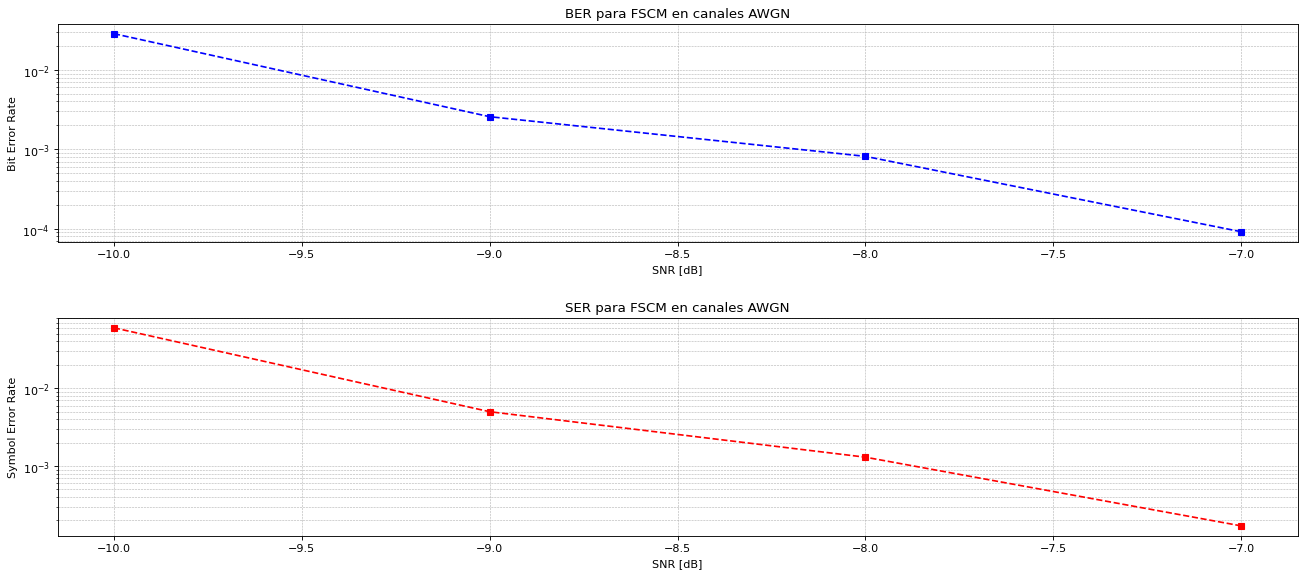

In [27]:
## Selector del tipo de simulacion
tipoDeSimulacion = int(input("Ingrese el número de simulación (1: Ideal, 2: AWGN, 3: Canal selectivo): "))

if tipoDeSimulacion == 1:
    ## Simulacion Ideal
    n = 3    # Cantidad de simbolos que queremos transmitir por trama
    SF = 10  # Spreading Factor para esta simulacion
    BW = 2 ** SF  # Ancho de banda, en el paper se define como 2 ** SF

    simulacion_ideal(n, SF, BW)

elif tipoDeSimulacion == 2:    
    ## Simulacion son Ruido AWGN
    SF = 7  # Spreading Factor para esta simulacion
    BW = 2 ** SF  # Ancho de banda, en el paper se define como 2 ** SF
    
    rango_snr_db = np.arange(-10, -6, 1)
    BERS = np.zeros(4, dtype=float)   # Array de 4 BER, cada uno correspondiente a cada SNR del array rango_snr_db
    SERS = np.zeros(4, dtype=float)    # Array de 4 SER, cada uno correspondiente a cada SNR del array rango_snr_db
    
    numSimulaciones = np.array([100, 1000, 10000, 100000])        # Cantidad de simulaciones por valor de SNR
    i = 0

    for snr_db in tqdm(rango_snr_db, desc=">> Simulacion con Ruido AWGN"):
        SER, BER = simulacion_con_awgn(SF, BW, snr_db, numSimulaciones[i])

        SERS[i] = SER 
        BERS[i] = BER

        i += 1

    print_grafica_ber_ser(BERS, SERS, rango_snr_db)

elif tipoDeSimulacion == 3:
    ## Simulacion con canal selectivo en frecuencia
    SF = 7    # Spreading Factor para esta simulacion
    BW = 2 ** SF    # Ancho de banda, en el paper se define como 2 ** SF
    rango_snr_db = np.arange(-9, -2, 1)
    
    BERS = np.zeros(7, dtype=float)   # Array de 4 BER, cada uno correspondiente a cada SNR del array rango_snr_db
    SERS = np.zeros(7, dtype=float)    # Array de 4 SER, cada uno correspondiente a cada SNR del array rango_snr_db
    
    numSimulaciones = np.array([100, 1000, 1000, 1000, 10000, 10000, 100000])        # Cantidad de simulaciones por valor de SNR
    i = 0

    for snr_db in tqdm(rango_snr_db, desc=">> Simulacion con Canal Selectivo en Frecuencia"):
        SER, BER = simulacion_con_canal_selectivo(SF, BW, snr_db, numSimulaciones[i])
    
        SERS[i] = SER 
        BERS[i] = BER

        i += 1

    print_grafica_ber_ser(BERS, SERS, rango_snr_db)

else: 
    print("Tipo de Simulacion No Valida...")